In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
%matplotlib inline
colors = ['lightblue', 'pink']
feature_keys = ['total words','total uniq', 'total wpt','D uniq','D words',\
                'D wpt','D pos_avg','P uniq','P words','P wpt','P pos_avg']
outcome = ['discDmind3','cumulative rating']
df_phase1  = pd.read_csv('phase1_lect_ata_new_df.csv')
df_phase2  = pd.read_csv('phase2_lect_ata_new_df.csv')
df = pd.concat([df_phase1,df_phase2])

df_sent  = pd.read_csv('all_w_sent.csv',encoding = "ISO-8859-1")
df_liwc  = pd.read_csv('all_w_liwc.csv',encoding = "ISO-8859-1")
#df_liwc = df_liwc.groupby(['Filename']).mean()
#df_sent = df_sent.groupby(['Filename']).mean()
def get_male_female_files(p_male,d_male):
	phase1_files = df_phase1[(df_phase1['isPatientMale']==p_male)&(df_phase1['isDoctorMale']==d_male)]['Filename'].tolist()
	phase2_files = df_phase2[(df_phase2['isPatientMale']==p_male)&(df_phase2['isDoctorMale']==d_male)]['Filename'].tolist()
	return phase1_files+phase2_files

male_doctor_file_names = get_male_female_files(0,1)+ get_male_female_files(1,1)
female_doctor_file_names = get_male_female_files(0,0)+ get_male_female_files(1,0)
male_patient_file_names = get_male_female_files(1,0)+ get_male_female_files(1,1)
female_patient_file_names = get_male_female_files(0,0)+ get_male_female_files(0,1)

maleD_femaleP_file_names = get_male_female_files(0,1)
maleD_maleP_file_names = get_male_female_files(1,1)
femaleD_femaleP_file_names = get_male_female_files(0,0)
femaleD_maleP_file_names = get_male_female_files(1,0)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
def get_divide_sent_cosine_sync(fold, type = 'pos'):
    file_names = df_sent['Filename'].tolist()
    file_set = set(file_names)
    new_dict = dict()
    out_size = 10
    for f in file_set:
        file_df = df_sent[df_sent['Filename'] == f]
        size = int(len(file_df)/out_size)
        new_dict[f] = np.zeros([fold])
        d = np.zeros([out_size])
        p = np.zeros([out_size])
        for k in range(out_size):
            df2 = file_df[(k*size):((k+1)*size)]
            dfp = df2[df2['Speaker'] == 'P'].dropna()
            dfd = df2[df2['Speaker'] == 'D'].dropna()
            d[k] = dfd['pos'].mean()
            p[k] = dfp['pos'].mean()
        #print(f,size,file_df[file_df['Speaker']=='P']['pos'])
        #d[np.isnan(d)]=np.nanmean(0.1)
        #p[np.isnan(p)]=np.nanmean(0.1)
        d = np.nan_to_num(d)
        p = np.nan_to_num(p)
        size = int(out_size/fold)
        for k in range(fold):
            new_dict[f][k] = euclidean(d[(k*size):((k+1)*size)].reshape(1,-1),p[(k*size):((k+1)*size)].reshape(1,-1))
    # print (new_dict)
    return new_dict

In [14]:
fold = 10
d = get_divide_sent_cosine_sync(fold)

<h2>Male-female Doctor Sync Trajectory</h2>

P =  0.21452574614756315  Male mean = 0.18596886545850516  Female mean = 0.18217649766991345


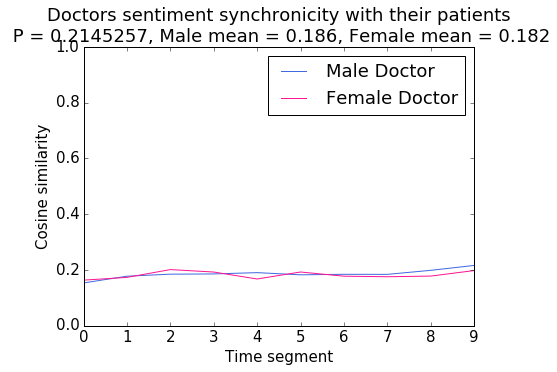

In [16]:
df_sync = pd.DataFrame(d)
df_sync = df_sync.T.reset_index().rename(index=str, columns={"index": "Filename"})
maleD = df_sync[df_sync['Filename'].isin(male_doctor_file_names)].mean(axis=1)
femaleD = df_sync[df_sync['Filename'].isin(female_doctor_file_names)].mean(axis=1)
print('P = ', mannwhitneyu(maleD,femaleD)[1],' Male mean =',maleD.mean(),' Female mean =',femaleD.mean())
male_sync = np.zeros([fold])
for f in male_doctor_file_names:
    for i in range(fold):
        male_sync[i] += d[f][i]
male_sync = male_sync/len(male_doctor_file_names)

female_sync = np.zeros([fold])
for f in female_doctor_file_names:
    for i in range(fold):
        female_sync[i] += d[f][i]
female_sync = female_sync/len(female_doctor_file_names)

plt.figure( figsize=(7, 5),dpi= 150, facecolor='w', edgecolor='k')
plt.plot(male_sync,color='royalblue',label="Male Doctor")
plt.plot(female_sync,color='deeppink',label="Female Doctor")
plt.title('Doctors sentiment synchronicity with their patients\n P = %0.7f, Male mean = %0.3f, Female mean = %0.3f'\
          %(mannwhitneyu(maleD,femaleD)[1],maleD.mean(),femaleD.mean()))
plt.ylabel('Cosine similarity')
plt.xlabel('Time segment')
plt.ylim(0,1)
plt.legend()
plt.savefig('Male-Female Doctor Sync Trajectory Euclid.png',bbox_inches='tight')
plt.show()

<h2> Sent Sync Trajectory with hi-lo Discordance </h2>

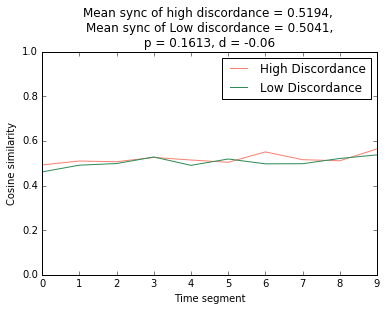

In [11]:
df_disc_sync = pd.merge(df_sync,df[['Filename','discDmind3']],how='inner',on = 'Filename').dropna()
hi = df_disc_sync[df_disc_sync['discDmind3'] >= 3] 
lo = df_disc_sync[df_disc_sync['discDmind3'] < 3] 

U, p = mannwhitneyu(hi[np.arange(fold)].mean(axis=1),lo[np.arange(fold)].mean(axis=1))
cliffd = 2*U/(len(hi)*len(lo)) -1

plt.plot(hi[np.arange(fold)].mean(),color = 'salmon',label = 'High Discordance')
plt.plot(lo[np.arange(fold)].mean(),color = 'seagreen',label = 'Low Discordance')
plt.ylabel('Cosine similarity')
plt.xlabel('Time segment')
plt.title('Mean sync of high discordance = %0.4f, \nMean sync of Low discordance = %0.4f,\n p = %0.4f, d = %0.2f '\
          %(hi[np.arange(fold)].mean().mean(),lo[np.arange(fold)].mean().mean(),p,cliffd))
plt.ylim(0.0,1)
plt.legend()
plt.show()

<h2>Male-female Doctors' Sync Trajectory with Hi-Lo Discordance</h2>

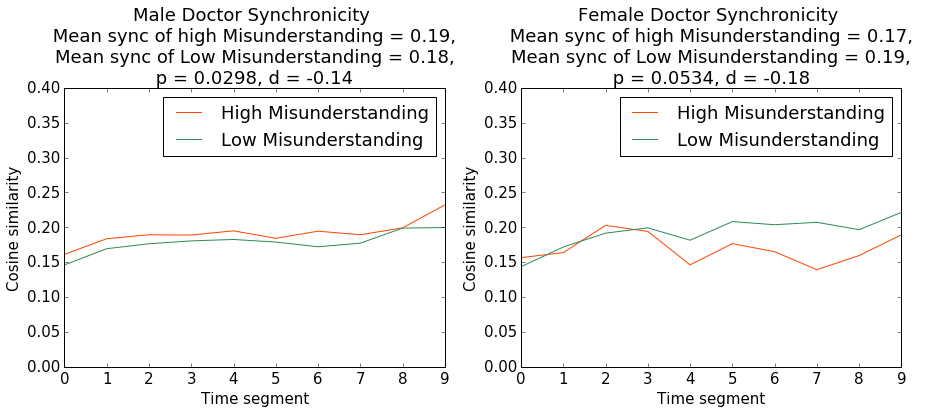

In [23]:
plt.rcParams.update({'font.size': 15})
df_disc_sync = pd.merge(df_sync,df[['Filename','discDmind3']],how='inner',on = 'Filename').dropna()
maleD_hi = df_disc_sync[(df_disc_sync['Filename'].isin(male_doctor_file_names)) & (df_disc_sync['discDmind3'] >= 3)] 
maleD_lo = df_disc_sync[(df_disc_sync['Filename'].isin(male_doctor_file_names)) & (df_disc_sync['discDmind3'] < 3)] 
femaleD_hi = df_disc_sync[(df_disc_sync['Filename'].isin(female_doctor_file_names)) & (df_disc_sync['discDmind3'] >= 3)] 
femaleD_lo = df_disc_sync[(df_disc_sync['Filename'].isin(female_doctor_file_names)) & (df_disc_sync['discDmind3'] < 3)]

U, p = mannwhitneyu(maleD_hi[np.arange(fold)].mean(axis=1),maleD_lo[np.arange(fold)].mean(axis=1))
cliffd = 2*U/(len(maleD_hi)*len(maleD_lo)) -1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(maleD_hi[np.arange(fold)].mean(),color = 'orangered',label = 'High Misunderstanding')
plt.plot(maleD_lo[np.arange(fold)].mean(),color = 'seagreen',label = 'Low Misunderstanding')
plt.ylabel('Cosine similarity')
plt.xlabel('Time segment')
plt.title('Male Doctor Synchronicity \n Mean sync of high Misunderstanding = %0.2f, \nMean sync of Low Misunderstanding = %0.2f,\n p = %0.4f, d = %0.2f '\
          %(maleD_hi[np.arange(fold)].mean().mean(),maleD_lo[np.arange(fold)].mean().mean(),p,cliffd))
plt.ylim(0.0,0.4)
plt.legend()

U, p = mannwhitneyu(femaleD_hi[np.arange(2,fold)].mean(axis=1),femaleD_lo[np.arange(fold)].mean(axis=1))
cliffd = 2*U/(len(femaleD_hi)*len(femaleD_lo))-1
plt.subplot(1,2,2)
plt.plot(femaleD_hi[np.arange(fold)].mean(),color = 'orangered',label = 'High Misunderstanding')
plt.plot(femaleD_lo[np.arange(fold)].mean(),color = 'seagreen',label = 'Low Misunderstanding')
plt.ylabel('Cosine similarity')
plt.xlabel('Time segment')
plt.title('Female Doctor Synchronicity \n Mean sync of high Misunderstanding = %0.2f, \nMean sync of Low Misunderstanding = %0.2f,\n p = %0.4f, d = %0.2f '\
          %(femaleD_hi[np.arange(fold)].mean().mean(),femaleD_lo[np.arange(fold)].mean().mean(),p,cliffd))
plt.ylim(0.0,0.4)
plt.legend()
plt.savefig('Male-female doctor sync trajetory with hi-lo discordance Eulcid.png',bbox_inches='tight')
plt.show()

<h2>Male-female Doctors' Sync Trajectory with Hi-Lo Cumulative Rating</h2>


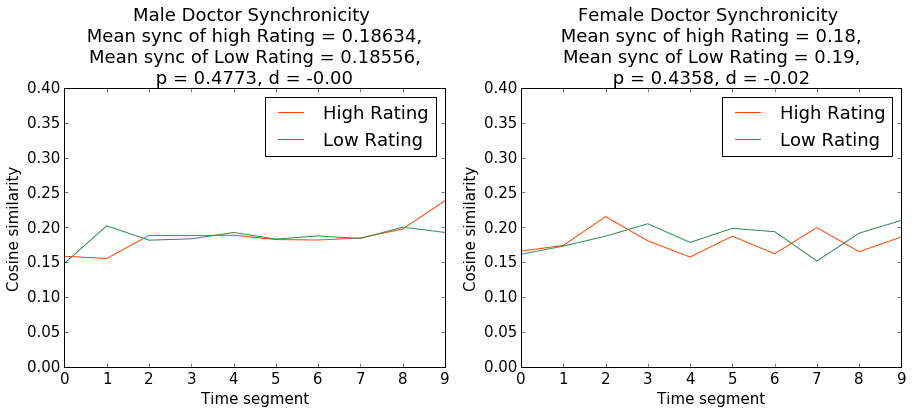

In [22]:
df_disc_sync = pd.merge(df_sync,df[['Filename','cumulative rating']],how='inner',on = 'Filename').dropna()
maleD_hi = df_disc_sync[(df_disc_sync['Filename'].isin(male_doctor_file_names)) & (df_disc_sync['cumulative rating'] >= 45)] 
maleD_lo = df_disc_sync[(df_disc_sync['Filename'].isin(male_doctor_file_names)) & (df_disc_sync['cumulative rating'] < 45)] 
femaleD_hi = df_disc_sync[(df_disc_sync['Filename'].isin(female_doctor_file_names)) & (df_disc_sync['cumulative rating'] >= 45)] 
femaleD_lo = df_disc_sync[(df_disc_sync['Filename'].isin(female_doctor_file_names)) & (df_disc_sync['cumulative rating'] < 45)]
U, p = mannwhitneyu(maleD_hi[np.arange(fold)].mean(axis=1),maleD_lo[np.arange(fold)].mean(axis=1))
cliffd = 2*U/(len(maleD_hi)*len(maleD_lo)) -1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(maleD_hi[np.arange(fold)].mean(),color = 'orangered',label = 'High Rating')
plt.plot(maleD_lo[np.arange(fold)].mean(),color = 'seagreen',label = 'Low Rating')
plt.ylabel('Cosine similarity')
plt.xlabel('Time segment')
plt.title('Male Doctor Synchronicity \n Mean sync of high Rating = %0.5f, \nMean sync of Low Rating = %0.5f,\n p = %0.4f, d = %0.2f '\
          %(maleD_hi[np.arange(fold)].mean().mean(),maleD_lo[np.arange(fold)].mean().mean(),p,cliffd))
plt.ylim(0.0,0.4)
plt.legend()

U, p = mannwhitneyu(femaleD_hi[np.arange(1,fold)].mean(axis=1),femaleD_lo[np.arange(fold)].mean(axis=1))
cliffd = 2*U/(len(femaleD_hi)*len(femaleD_lo)) -1

plt.subplot(1,2,2)
plt.plot(femaleD_hi[np.arange(fold)].mean(),color = 'orangered',label = 'High Rating')
plt.plot(femaleD_lo[np.arange(fold)].mean(),color = 'seagreen',label = 'Low Rating')
plt.ylabel('Cosine similarity')
plt.xlabel('Time segment')
plt.title('Female Doctor Synchronicity \n Mean sync of high Rating = %0.2f, \nMean sync of Low Rating = %0.2f,\n p = %0.4f, d = %0.2f '\
          %(femaleD_hi[np.arange(fold)].mean().mean(),femaleD_lo[np.arange(fold)].mean().mean(),p,cliffd))
plt.ylim(0.0,0.4)
plt.legend()
plt.savefig('Male-female doctor sync trajetory with hi-lo Rating Eulcid.png',bbox_inches='tight')
plt.show()